# Discount Dividend Model (DDM) share price analysis

HSBC share price dropped more than 50% this year, making it one of the worst stock on the Hong Kong stock market. HSBC used to be the best defensive stock to buy for Hong Kong, given its stable growing and persistent dividend policy. However, the dividend has been suspended due to COVID-19 and UK government policy. Therefore, all strategies relying on stable dividend cash flow from HSBC will need to be reconsidered.  

This model by default use HSBC as target, but it can also analyze other stock as long as price and dividend data is available.

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 8)
# %matplotlib inline
# %matplotlib widget

### Global Parameters

In [2]:
TICKER = '0005.HK'
START = '2010-01-01'
COST_OF_EQUITY = 0.10
SAVE_PATH = './data'

### Download Price and Dividend Data

In [3]:
# download using yfinance library
# repo: https://github.com/ranaroussi/yfinance
def download_data(ticker):
    import yfinance as yf
    try:
        price = yf.Ticker(ticker).history(start=START)
        if len(price) > 0:
            price.to_csv(f'{SAVE_PATH}/{ticker}.csv')
            print(f'Sucessfully downloaded {ticker}.csv')
    except Exception as e:
        print(f'Failed to download {ticker} | {str(e)}')        

# uncomment and run this cell to force download and update price data again
# download_data(TICKER)

# auto download if price data doesn't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.isfile(f'./data/{TICKER}.csv'):
    download_data(TICKER)

In [4]:
price = pd.read_csv(f'./data/{TICKER}.csv', index_col=0, parse_dates=True)
print(price)    

              Open    High     Low   Close     Volume  Dividends  Stock Splits
Date                                                                          
2010-01-04  55.387  55.697  55.016  55.294   10381759        0.0             0
2010-01-05  55.883  56.162  55.821  56.038   16914189        0.0             0
2010-01-06  56.565  56.998  56.534  56.750   20033996        0.0             0
2010-01-07  56.812  56.843  56.286  56.534   11163952        0.0             0
2010-01-08  56.688  57.091  56.595  56.812   15683744        0.0             0
...            ...     ...     ...     ...        ...        ...           ...
2020-09-21  30.250  30.450  29.300  29.300  120212700        0.0             0
2020-09-22  28.500  28.800  28.300  28.700   87310260        0.0             0
2020-09-23  28.450  28.800  27.500  28.750  109384300        0.0             0
2020-09-24  28.450  28.650  27.900  28.600   63528720        0.0             0
2020-09-25  28.550  28.700  27.900  28.200   4246582

### Plot Stock Price

<AxesSubplot:>

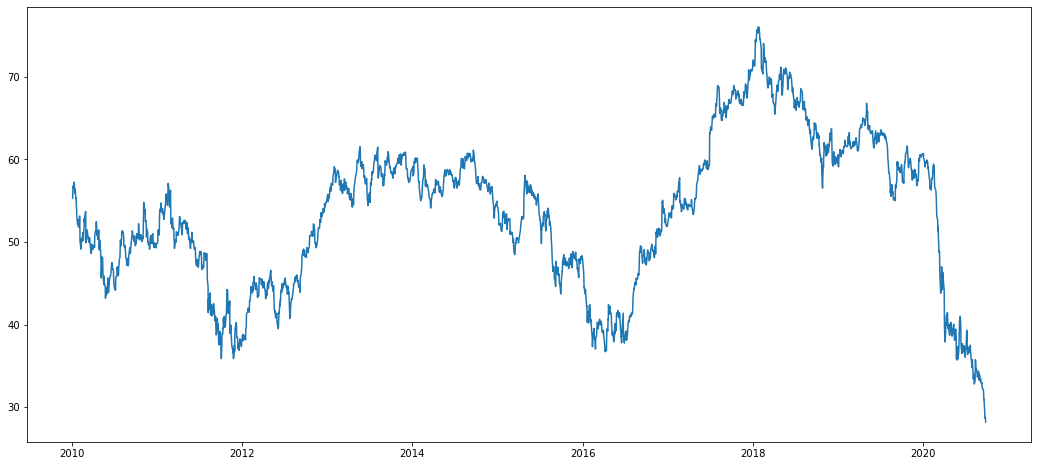

In [5]:
sns.lineplot(data=price.Close)

HSBC share price has dropped to record low level

### Plot Dividends

<AxesSubplot:>

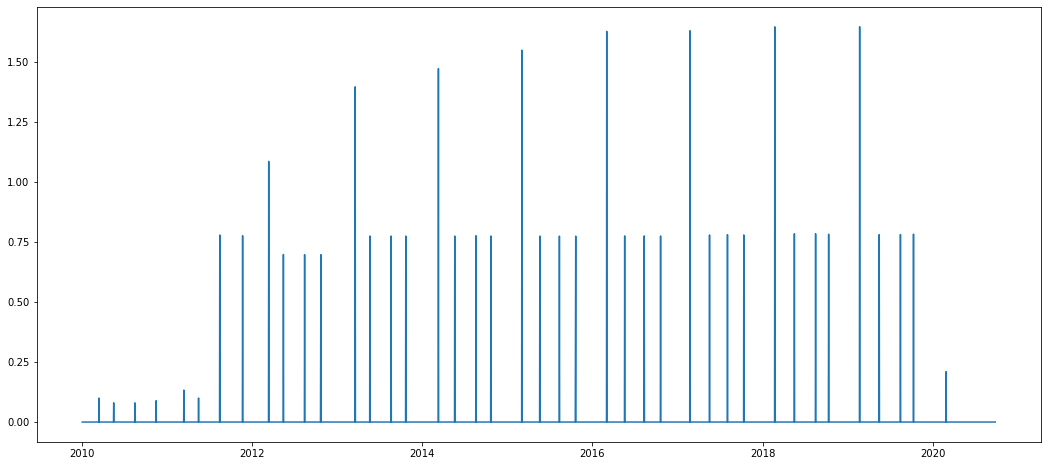

In [6]:
sns.lineplot(data=price.Dividends)

According to the record from Yahoo Finance, HSBC has a very stable growing dividend policy before 2020. 

### Rolling 12 Months Dividend Cash Flow
Valuation model calculate intrinsic value on annual cash flow basis, therefore we need to convert quarterly cash flow to annual cash flow. The easiest way to do is to rolling sum all dividend in the past 12 months. To address the problem that some period may not include the final dividend cash flow, I also added a 3 months moving average to the resulting time series.

In [7]:
dvd_roll12m = price.Dividends.rolling(252).sum()
dvd_roll12m_ma3m = dvd_roll12m.rolling(63).mean()

<AxesSubplot:>

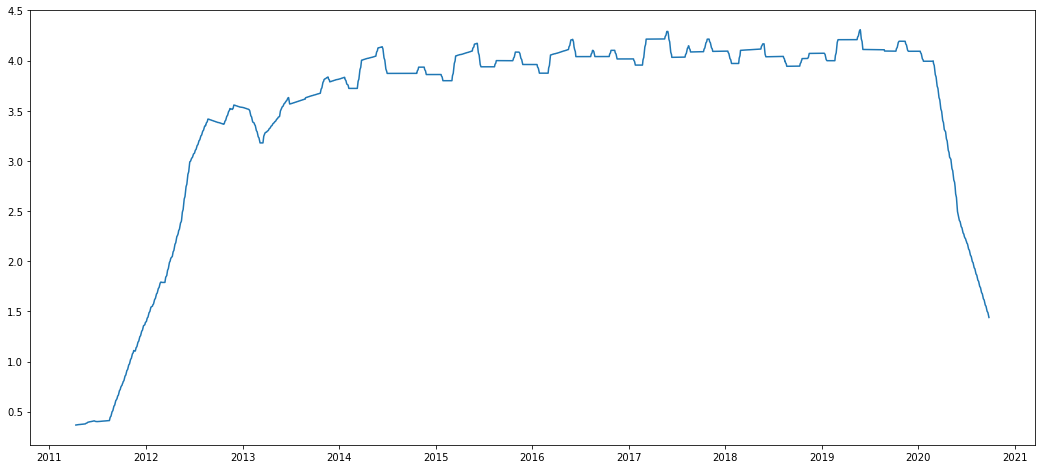

In [8]:
sns.lineplot(data=dvd_roll12m_ma3m)

### Discounted Dividend Model (1-stage)

Here we defined the 1-stage Discounted Dividend Model.

In [9]:
def DDM_1s(D, g=0.0, r=COST_OF_EQUITY):
    """
    Calculate the intrinsic value of a dividend-paying stock
    
    Parameters
    ----------
    D : float
        expected 12m dividend
    r : float
        cost of capital equity
    g : float
        perpetual growth rate of dividend

    Returns
    -------
    float
        intrinsic value of the stock
    
    Raises
    ------
    None
    """
    def model(D, g, r):
        if D < 0 or r < 0 or r < g:
            return np.nan
        else:
            return D * (1 + g) / (r - g)
    
    if np.isscalar(D):
        return model(D, g, r)
    else:
        return np.vectorize(model)(D, g, r)

Then we calculate the rolling price target as given by the valuation model based on every rolling 12 months dividend value. We use 3 different level of growth rate, namely 0%, 2.5% and 5%, to see how growth rate assumption will affect the target price.

In [10]:
values = [pd.Series(DDM_1s(dvd_roll12m_ma3m, r=COST_OF_EQUITY, g=g), 
                      name=(f'DDM_1s (g={g:+.1%})'),
                      index=dvd_roll12m_ma3m.index) for g in [0.000, 0.025, 0.050]]

C:\Users\WYKONG\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


### Plot Target Price vs Stock Price

<AxesSubplot:title={'center':'0005.HK: DDM 1-stage intrinsic value vs stock price'}, xlabel='Date'>

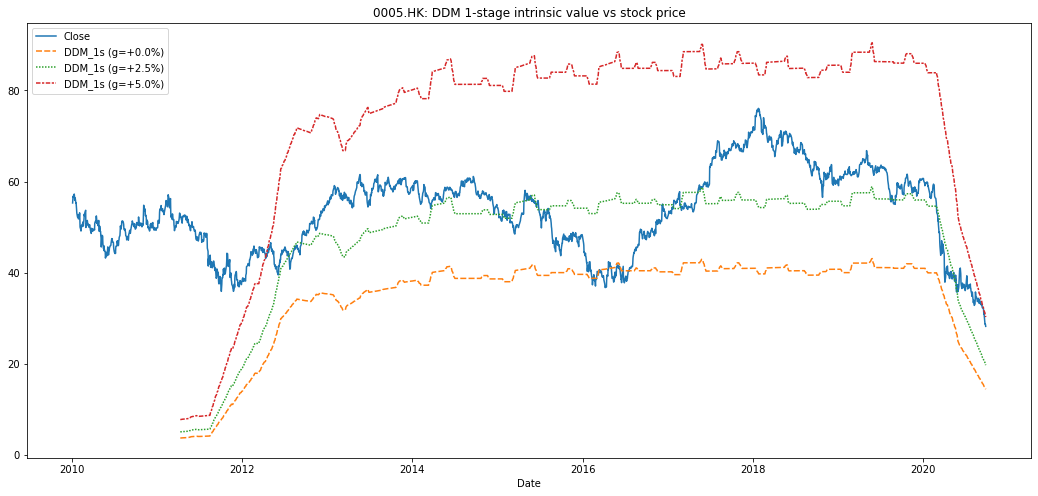

In [11]:
plt.title(f'{TICKER}: DDM 1-stage intrinsic value vs stock price')
sns.lineplot(data=pd.concat([price.Close, *values], axis=1))

As we can see, the assumption of 2.5% growth best fit the actual share price. In very short term, this model may not explain the change of share price very well, but it can give an approximation to whether the stock is over or undervalued.

### Discounted Dividend Model (2-stages)

There is also a more complicated version of DDM, which assumes an initial high(or low) growth period, following is a normal perpetual growth period. We calculate the rolling target price as usual, and also tried different initial growth rate.

In [12]:
def DDM_2s(D, G=0.0, N=5, g=0.0, r=COST_OF_EQUITY):
    """
    Calculate the intrinsic value of a dividend-paying stock
    assuming both initial and perpetual growth stages
    
    Parameters
    ----------
    D : float
        expected 12m dividend
    N : float
        number of initial growth period
    G : float
        initial growth rate of dividend
    r : float
        cost of capital equity
    g : float
        perpetual growth rate of dividend

    Returns
    -------
    float
        intrinsic value of the stock
    
    Raises
    ------
    None
    """
    def model(D, G, N, g, r):
        if any([D < 0, N < 0, G < -1, r < 0, r < g]):
            return np.nan
        else:
            init_stage = sum(D*(1+G)**i/(1+r)**i for i in range(1, N+1))
            term_stage = D*(1+G)**N*(1+g)/(r-g)/(1+r)**N
            return init_stage + term_stage
        
    if np.isscalar(D):
        return model(D, G, N, g, r)
    else:
        return np.vectorize(model)(D, G, N, g, r)

In [13]:
values = [pd.Series(DDM_2s(dvd_roll12m_ma3m, G=G, r=COST_OF_EQUITY, g=0.025), 
                      name=(f'DDM_2s (G={G:+.1%})'),
                      index=dvd_roll12m_ma3m.index) for G in [-0.05, 0.000, +0.080]]

C:\Users\WYKONG\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


### Plot Target Price vs Stock Price

<AxesSubplot:title={'center':'0005.HK: DDM 2-stages intrinsic value vs stock price'}, xlabel='Date'>

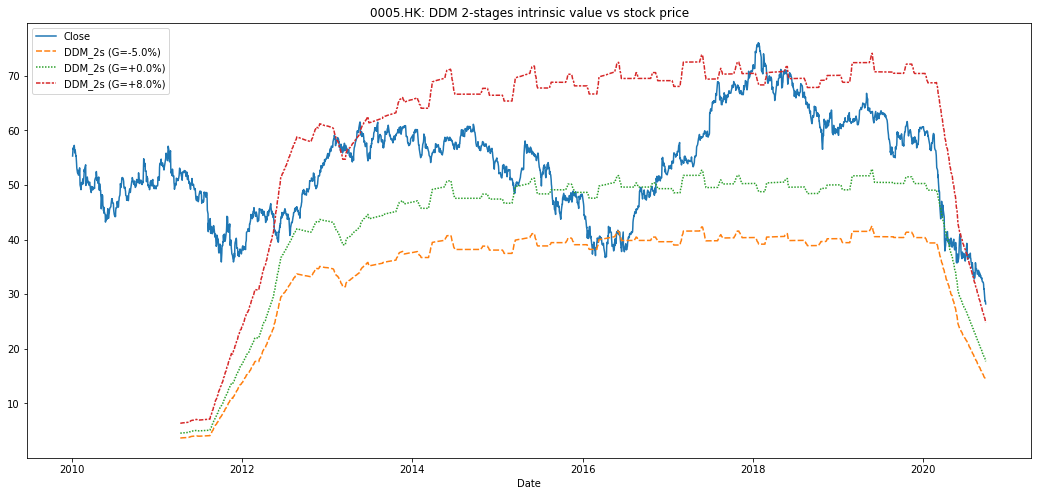

In [14]:
plt.title(f'{TICKER}: DDM 2-stages intrinsic value vs stock price')
sns.lineplot(data=pd.concat([price.Close, *values], axis=1))

### Model Implied Dividend Growth Rate

If we reverse the 1-stage DDM function, we can use the market price to calculate the implied growth rate of the stock.

In [15]:
def DDM_1s_inv(P, D, r=COST_OF_EQUITY):
    return (P*r - D) / (P + D)

In [16]:
implied = DDM_1s_inv(price.Close, dvd_roll12m_ma3m).rename('implied_g')

<AxesSubplot:title={'center':'0005.HK: DDM 1-stages implied growth rate'}>

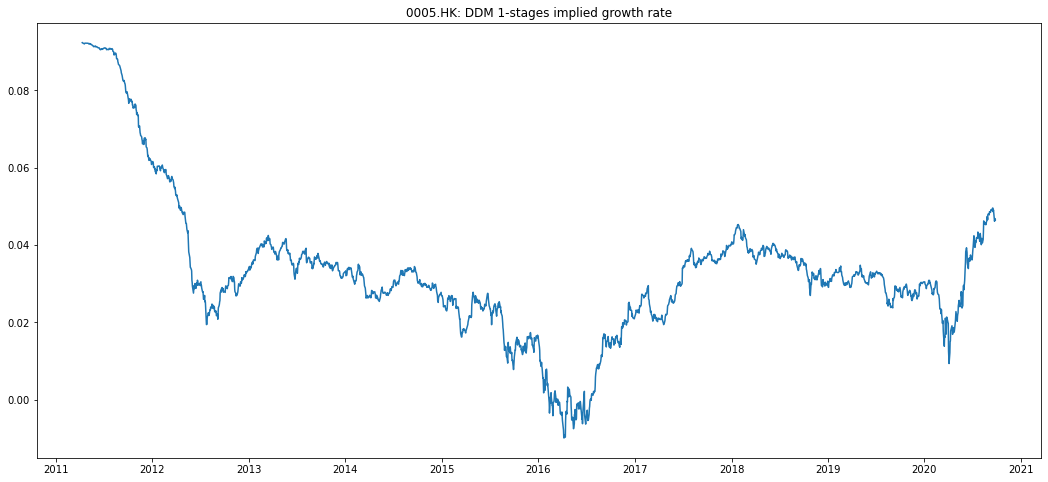

In [17]:
plt.title(f'{TICKER}: DDM 1-stages implied growth rate')
sns.lineplot(data=implied)